In [3]:
import dlib
import cv2
import os
import glob
from preprocessing.scarpping_component import extract_component_by_images

# Initialize dlib face detector and shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")

# Hapus Semua File Hasil Test
files = glob.glob('hasil_test/*')
for f in files:
    os.remove(f)

components_setup = {
    'mulut': {
        'object_name': 'Mouth',
        'object_rectangle': {"x_right": 54, "x_left": 48, "y_highest": 52, "y_lowest": 57},
        'pixel_shifting': {"pixel_x": 25, "pixel_y": 10},
        'object_dimension': {'width': 140, 'height': 40}
    },
    'alis': {
        'object_name': 'Eyebrows',
        'object_rectangle': {"x_right": 26, "x_left": 17, "y_highest": 18, "y_lowest": 25},
        'pixel_shifting': {"pixel_x": 20, "pixel_y": 15},
        'object_dimension': {'width': 200, 'height': 40}
    }
    # 'mata_kanan': {
    #     'object_name': 'eye_right',
    #     'object_rectangle': {"x_right": 45, "x_left": 42, "y_highest": 43, "y_lowest": 47},
    #     'pixel_shifting': {"pixel_x": 20, "pixel_y": 15},
    #     'object_dimension': {'width': 81, 'height': 43}
    # },
    # 'alis_kiri': {
    #     'object_name': 'eyebrow_left',
    #     'object_rectangle': {"x_right": 21, "x_left": 17, "y_highest": 18, "y_lowest": 21},
    #     'pixel_shifting': {"pixel_x": 15, "pixel_y": 5},
    #     'object_dimension': {'width': 111, 'height': 28}
    # },
    # 'alis_kanan': {
    #     'object_name': 'eyebrow_right',
    #     'object_rectangle': {"x_right": 26, "x_left": 22, "y_highest": 25, "y_lowest": 22},
    #     'pixel_shifting': {"pixel_x": 15, "pixel_y": 5},
    #     'object_dimension': {'width': 111, 'height': 28}
    # }
}

def create_blocks(image, block_size):
    # if len(image.shape) < 3 or image.shape[2] != 3:
    #     print("Gambar tidak memiliki tiga saluran warna (BGR).")
    #     return image

    # Ensure the directory exists
    os.makedirs('testing', exist_ok=True)

    h, w = image.shape[:2]
    block_number = 1

    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            if x + block_size <= w and y + block_size <= h:
                if block_number == 1:
                    # Export the block starting from (0, 0) with size 7x7
                    block = image[0:block_size, 0:block_size]
                    cv2.imwrite('testing/frame_70_blok_1.jpg', block)
                else:
                    # Change color to red (BGR format: (0, 0, 255))
                    cv2.rectangle(image, (x, y), (x + block_size, y + block_size), (0, 0, 0), 1)
                    cv2.putText(image, str(block_number), (x + 2, y + 12), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
                block_number += 1
    return image

# Load image
# image_path = 'images/cina.jpg'

# image_path = 'dataset/casme_custom_from_one/Surprise/05_EP03_06/img2.jpg'

# image_path = 'dataset/casme_custom_from_one/Happiness/05_EP03_01/img50.jpg'
# image_path = 'dataset/casme_custom_from_one/Happiness/01_EP02_01f/img70.jpg'
image_path = 'images/gambar1.png'

image = cv2.imread(image_path)
if image is None:
    print(f"Error loading image from path: {image_path}")
else:
    # Resize image
    image = cv2.resize(image, (600, 500))
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    # Detect faces
    rects = detector(gray)

    if len(rects) == 0:
        print("No faces detected.")
    else:
        for rect in rects:
            # Draw rectangle around the face
            cv2.rectangle(image, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (0, 255, 0), 2)
            
            # Predict facial landmarks
            shape = predictor(gray, rect)

            for component_name, component_info in components_setup.items():
                print(f"\nProcessing {component_info['object_name']}")

                # Extract component by image
                data_blocks_image_current = extract_component_by_images(
                    image=image,
                    shape=shape,
                    frameName=component_name,
                    objectName=component_info['object_name'],
                    objectRectangle=component_info['object_rectangle'],
                    pixelShifting=component_info['pixel_shifting'],
                    objectDimension=component_info['object_dimension']
                )

                # Without blocks
                output_path = f'hasil_test/{component_info["object_name"]}.jpg'
                cv2.imwrite(output_path, data_blocks_image_current)
                print(f"Image without blocks saved at: {output_path}")

                # Resize component image
                scale_factor = 5  # Increase size by 5 times
                resized_component_image = cv2.resize(data_blocks_image_current, 
                                                     (data_blocks_image_current.shape[1] * scale_factor, 
                                                      data_blocks_image_current.shape[0] * scale_factor))

                # Create 5x5 blocks for the resized component image
                block_size = 7 * scale_factor  # Adjust block size according to the scale factor
                component_image_with_blocks = create_blocks(resized_component_image, block_size)

                # Save the result
                output_path = f'hasil_test/{component_info["object_name"]}_with_blocks.jpg'
                cv2.imwrite(output_path, component_image_with_blocks)

                # ukuran gambar
                print(f"Ukuran gambar: {image.shape[1]} x {image.shape[0]}")

                # debug
                # print landamark yang digunakan dalam setiap component
                # print(f"Landmark yang digunakan dalam {component_info['object_name']}:")
                # for key, value in component_info['object_rectangle'].items():
                #     print(f"{key}: {value}")

                print(f"Image with blocks saved at: {output_path}")

                object_rectangle = component_info['object_rectangle']
                pixel_shifting = component_info['pixel_shifting']
                object_dimension = component_info['object_dimension']
                
                # Setup shape part dari parameter objectRectangle
                x_right = shape.part(object_rectangle["x_right"]).x
                x_left = shape.part(object_rectangle["x_left"]).x
                y_highest = shape.part(object_rectangle["y_highest"]).y
                y_lowest = shape.part(object_rectangle["y_lowest"]).y

                print(f"x_right: {x_right}, x_left: {x_left}, y_highest: {y_highest}, y_lowest: {y_lowest}")
                
                # Setup shape part dari parameter pixelShifting
                # Menggeser tepi kiri sisi gambar sebanyak variabel pixel_shifting ke kiri
                x_left -= pixel_shifting["pixel_x"]
                # Menggeser tepi atas sisi gambar sebanyak variabel pixel_shifting ke atas
                y_highest -= pixel_shifting["pixel_y"]
                
                # Memastikan koordinat tetap berada dalam batas size gambar
                x_left = max(0, x_left)
                y_highest = max(0, y_highest)
                width_object = min(object_dimension["width"], image.shape[1] - x_left)
                height_object = min(object_dimension["height"], image.shape[0] - y_highest)

                
                # Draw the rectangle of the component on the original image
                cv2.rectangle(gray_bgr, (x_left, y_highest),
                            (x_left + width_object, y_highest + height_object),
                            (0, 0, 255), 2)
                
                # print koordinat cv2.rectangle
                print(f"x_left: {x_left}, y_highest: {y_highest}, width_object: {width_object}, height_object: {height_object}")
                
        # Save image with face detection and components rectangles for debugging
        debug_image_path = 'hasil_test/detected_faces_with_components.jpg'

        # Masking tiap landmark
        for i in range(0, 68):
            x = shape.part(i).x
            y = shape.part(i).y
            cv2.circle(gray_bgr, (x, y), 1, (0, 0, 255), -1)
            cv2.putText(gray_bgr, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)

        cv2.imwrite(debug_image_path, gray_bgr)
        print(f"Image with face detection and components saved at: {debug_image_path}")
        print("Processing completed.")



Processing Mouth
Image without blocks saved at: hasil_test/Mouth.jpg
Ukuran gambar: 600 x 500
Image with blocks saved at: hasil_test/Mouth_with_blocks.jpg
x_right: 360, x_left: 235, y_highest: 340, y_lowest: 383
x_left: 210, y_highest: 330, width_object: 140, height_object: 40

Processing Eyebrows
Image without blocks saved at: hasil_test/Eyebrows.jpg
Ukuran gambar: 600 x 500
Image with blocks saved at: hasil_test/Eyebrows_with_blocks.jpg
x_right: 437, x_left: 157, y_highest: 184, y_lowest: 182
x_left: 137, y_highest: 169, width_object: 200, height_object: 40
Image with face detection and components saved at: hasil_test/detected_faces_with_components.jpg
Processing completed.


In [ ]:
import cv2
import os

def create_blocks(image_path, block_size):
    # Read the image from the given path
    image = cv2.imread(image_path)

    if image is None:
        print(f"Failed to load image from {image_path}")
        return

    # Ensure the directory exists
    os.makedirs('testing', exist_ok=True)

    h, w = image.shape[:2]
    block_number = 1

    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            if x + block_size <= w and y + block_size <= h:
                if block_number == 1:
                    # Export the block starting from (0, 0) with size 7x7
                    block = image[0:block_size, 0:block_size]
                    cv2.imwrite('testing/frame_01_blok_1.jpg', block)
                else:
                    # Change color to red (BGR format: (0, 0, 255))
                    cv2.rectangle(image, (x, y), (x + block_size, y + block_size), (0, 0, 0), 1)
                    cv2.putText(image, str(block_number), (x + 2, y + 12), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
                block_number += 1

    return image

# Example usage:
block_size = 7
image_path = 'mouth_regions/Rendah/Abdul Aziz_clip1/mouth_img1.jpg'
result_image = create_blocks(image_path, block_size)
if result_image is not None:
    cv2.imwrite('testing/result_Abdul_Aziz_img1.jpg', result_image)

Failed to load image from mouth_img1.jpg


In [12]:
import cv2
import os

def create_blocks(image_path, block_size):
    # Check if file exists first
    if not os.path.exists(image_path):
        print(f"Error: File '{image_path}' does not exist!")
        return None
        
    # Read the image from the given path
    image = cv2.imread(image_path)

    if image is None:
        print(f"Failed to load image from '{image_path}'")
        return None

    print(f"Successfully loaded image with dimensions: {image.shape}")

    # Ensure the directory exists
    os.makedirs('testing', exist_ok=True)

    h, w = image.shape[:2]
    block_number = 1

    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            if x + block_size <= w and y + block_size <= h:
                if block_number == 1:
                    # Export the block starting from (0, 0) with size 7x7
                    block = image[0:block_size, 0:block_size]
                    cv2.imwrite('testing/frame_01_blok_1.jpg', block)
                else:
                    # Change color to red (BGR format: (0, 0, 255))
                    cv2.rectangle(image, (x, y), (x + block_size, y + block_size), (0, 0, 0), 1)
                    cv2.putText(image, str(block_number), (x + 2, y + 12), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
                block_number += 1

    return image

# Example usage:
if __name__ == "__main__":
    # Print current directory to help with debugging
    print(f"Current working directory: {os.getcwd()}")
    
    block_size = 5
    
    # Try with a different path - provide path relative to current directory
    # For example, if your image is in 'data/images' folder:
    image_path = 'images/mouth_img1.jpg'  # Adjust this path based on your file location
    
    # Or try with absolute path (uncomment and modify)
    # image_path = 'D:/skripsi-ekspresi-mikro/data/images/mouth_img1.jpg'
    
    print(f"Attempting to load image from: {os.path.abspath(image_path)}")
    
    result_image = create_blocks(image_path, block_size)
    
    if result_image is not None:
        output_path = 'testing/result_processed_image.jpg'
        cv2.imwrite(output_path, result_image)
        print(f"Successfully saved output image to {output_path}")
    else:
        print("Image processing failed. Please check the file path.")

Current working directory: d:\skripsi-ekspresi-mikro\services\ml-pipeline
Attempting to load image from: d:\skripsi-ekspresi-mikro\services\ml-pipeline\images\mouth_img1.jpg
Successfully loaded image with dimensions: (50, 100, 3)
Successfully saved output image to testing/result_processed_image.jpg


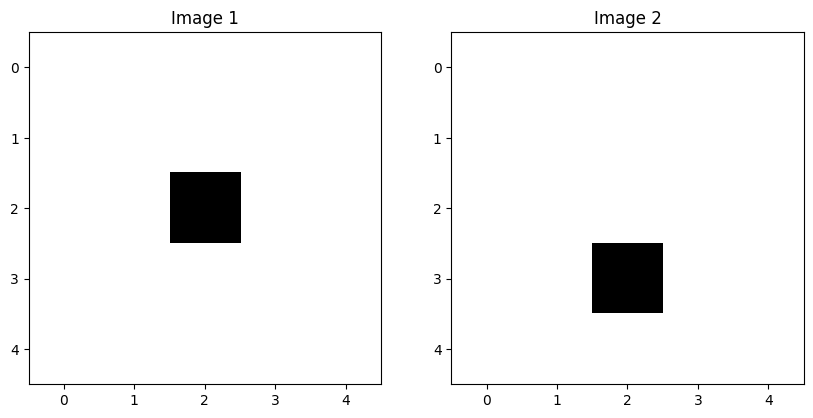

Hasil POC :
 Blok ke-1:
POC Value:
[[8.19223441e-17 7.38769921e-17 1.11022302e-16 7.16240947e-17
  8.34390160e-17]
 [7.18126095e-17 6.99278249e-17 7.10542736e-17 7.21807223e-17
  7.02959376e-17]
 [7.58335951e-19 1.12644871e-18 0.00000000e+00 1.12644871e-18
  7.58335951e-19]
 [2.69972397e-17 1.12644871e-18 1.00000000e+00 1.12644871e-18
  2.85139116e-17]
 [2.46590663e-17 3.27044182e-17 4.44089210e-18 3.49573157e-17
  2.31423944e-17]]
Koordinat Awal: [5. 5.]
Rectangle: [0. 0. 5. 5.]

Hasil Vektor : [[ 2.  2.  0.  1.  0. -1.]]
Hasil Quadran : [['0' 0 -1 270.0 1.0 'Q4']]
Nilai Fitur Dataset {'X1': 0, 'Y1': -1, 'Tetha1': 270.0, 'Magnitude1': 1.0}


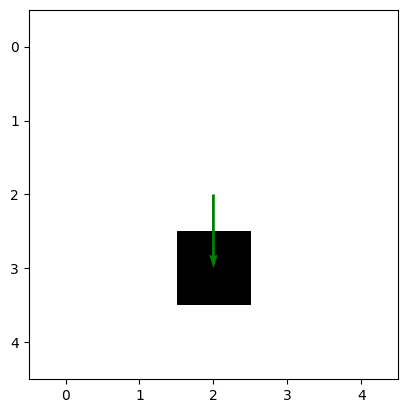

In [10]:
# Extraction Feature POC, Vektor, Quadran Test
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from feature_extraction.poc import POC
from feature_extraction.vektor import Vektor
from feature_extraction.quadran import Quadran


# Create two 5x5 pixel images with all white pixels
image1 = np.ones((5, 5), dtype=np.uint8) * 255
image2 = np.ones((5, 5), dtype=np.uint8) * 255

# Set one black pixel in image1
image1[2, 2] = 0

# Randomly select a position for the black pixel in image2
new_position = (np.random.randint(5), np.random.randint(5))

# Set the black pixel in the new position
image2[new_position] = 0

# Display the images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1, cmap='gray')
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(image2, cmap='gray')
plt.title('Image 2')

plt.show()


# Inisiasi class POC
initPOC = POC(image1, image2, 5)
# Pemanggilan fungsi pocCalc() untuk menghitung nilai POC disetiap gambar
valPOC = initPOC.getPOC() 

# Format hasil POC agar lebih manusiawi
formatted_poc = '\n'.join([f"Blok ke-{i+1}:\nPOC Value:\n{valPOC[0][:,:,i]}\nKoordinat Awal: {valPOC[1][i]}\nRectangle: {valPOC[2][i]}\n" for i in range(valPOC[0].shape[2])])

print('Hasil POC :\n', formatted_poc)

# Pemanggilan class dan method untuk menampilkan quiver / gambar panah
initQuiv = Vektor(valPOC, 5)
quivData = initQuiv.getVektor() 
print('Hasil Vektor :', quivData)

# Quadran
initQuadran = Quadran(quivData) 
quadran = initQuadran.getQuadran()

print('Hasil Quadran :' , quadran)

frame_data = {}

for i, quad in enumerate(quadran):
        # --- Setup bagian Nilai Fitur Dataset ---
        # Set data kedalam frame_data sesuai column nya
        frame_data[f'X{i+1}'] = quad[1]
        frame_data[f'Y{i+1}'] = quad[2]
        frame_data[f'Tetha{i+1}'] = quad[3]
        frame_data[f'Magnitude{i+1}'] = quad[4]

print("Nilai Fitur Dataset", frame_data)


# Menampilkan gambar dengan quiver
plt.imshow(np.uint8(image2), cmap='gray')
plt.quiver(quivData[:, 0], quivData[:, 1], quivData[:, 2], quivData[:, 3], scale=1, scale_units='xy', angles='xy', color="g")
plt.show()

In [16]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Directory containing the images
directory = 'dataset/training_images'

# Periksa struktur direktori
print("Isi direktori utama:")
for item in os.listdir(directory):
    full_path = os.path.join(directory, item)
    if os.path.isdir(full_path):
        print(f"- {item}/ (Folder)")
        # Lihat isi subfolder pertama
        try:
            subdir_items = os.listdir(full_path)
            if subdir_items:
                print(f"  - Contoh isi: {subdir_items[:3]}")
        except:
            print("  - Tidak dapat membaca isi folder")
    else:
        print(f"- {item} (File)")

# Jika ingin mencari gambar di level subfolder:
print("\nMencari gambar di semua subfolder...")
image_files = []

for root, dirs, files in os.walk(directory):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            # Simpan path relatif dari direktori utama
            rel_path = os.path.relpath(os.path.join(root, file), directory)
            image_files.append(rel_path)
            
image_files.sort()
print(f"Total gambar ditemukan: {len(image_files)}")
if image_files:
    print("Contoh path gambar:")
    for path in image_files[:5]:
        print(f"- {path}")

Isi direktori utama:
- Rendah/ (Folder)
  - Contoh isi: ['Abdul Aziz_clip1', 'Abdul Aziz_clip2', 'Abian Agung Shafiqri_clip1']
- Sangat Rendah/ (Folder)
  - Contoh isi: ['Afrizal Dwi S_clip1', 'Afrizal Dwi S_clip2', 'Andreagazy Iza A_clip1']
- Sangat Tinggi/ (Folder)
  - Contoh isi: ['Achmad Mufid_clip1', 'Achmad Mufid_clip2', 'Daffa Yudisa A_clip1']
- Tinggi/ (Folder)
  - Contoh isi: ['Abid Gimnastyar Alfiansyah_clip1', 'Abid Gimnastyar Alfiansyah_clip2', 'Ahmad Fathir Syafaat_clip1']

Mencari gambar di semua subfolder...
Total gambar ditemukan: 40040
Contoh path gambar:
- Rendah\Abdul Aziz_clip1\img1.jpg
- Rendah\Abdul Aziz_clip1\img10.jpg
- Rendah\Abdul Aziz_clip1\img100.jpg
- Rendah\Abdul Aziz_clip1\img101.jpg
- Rendah\Abdul Aziz_clip1\img102.jpg


In [ ]:
import cv2
import os
import pandas as pd

# Fungsi untuk mendapatkan durasi video dan total frame
def get_video_info(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None, None
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps
    cap.release()
    return duration, frame_count

# Data yang diberikan
data = {
    "Label": ["Rendah", "Rendah", "Rendah", "Rendah", "Rendah", "Rendah", "Rendah",
              "Sangat rendah", "Sangat rendah", "Sangat rendah", "Sangat rendah", "Sangat rendah", "Sangat rendah", "Sangat rendah",
              "Tinggi", "Tinggi", "Tinggi", "Tinggi", "Tinggi", "Tinggi", "Tinggi",
              "Sangat tinggi", "Sangat tinggi", "Sangat tinggi", "Sangat tinggi", "Sangat tinggi", "Sangat tinggi", "Sangat tinggi"],
    "Nama File": ["03_EP19_08", "17_EP13_04", "19_EP16_02", "20_EP06_03", "24_EP02_02f", "25_EP09_02", "25_EP18_04f",
                  "01_EP02_01f", "05_EP03_01", "06_EP01_01", "09_EP05_05", "09_EP15_05", "14_EP09_03", "17_EP06_07",
                  "17_EP15_01", "17_EP15_03", "19_EP19_04", "24_EP07_01", "24_EP07_04f", "24_EP10_03", "26_EP15_01",
                  "02_EP14_01", "05_EP03_06", "05_EP04_05", "05_EP12_03f", "06_EP02_31", "19_EP19_02", "24_EP18_03"]
}

# Menghitung jumlah data label dan nama file
data_count = len(data["Label"])

# Inisiasi list untuk menyimpan durasi video dan total frame
durations = []
total_frames = []

# Loop untuk mendapatkan durasi video dan total frame
for i in range(data_count):
    # Mendapatkan path video
    video_path = f'dataset/CASME2/CASME2/{data["Label"][i].capitalize()}/Video_Image_RAW 200fps/{data["Nama File"][i]}.avi'

    # Memeriksa apakah file video ada
    if os.path.exists(video_path):
        # Mendapatkan durasi video dan total frame
        duration, frame_count = get_video_info(video_path)
        # Memperbaiki tulisan durasi video dengan presisi tinggi tapi masih mudah dibaca
        duration = f"{duration:.2f} detik" if duration is not None else None
        durations.append(duration)
        total_frames.append(frame_count)
    else:
        durations.append(None)
        total_frames.append(None)
        print(f"Video Path: {video_path} - File tidak ditemukan")

# Menambahkan durasi dan total frame ke data
data["Durasi"] = durations
data["Total Frame"] = total_frames

# Membuat DataFrame dari data
df = pd.DataFrame(data)

# Menyimpan DataFrame ke file Excel
output_file = 'hasil_durasi_video_dan_total_frame.xlsx'
df.to_excel(output_file, index=False)

print(f"Data durasi video dan total frame telah disimpan di {output_file}")


In [17]:
import cv2
import os
import pandas as pd

# Fungsi untuk mendapatkan durasi video dan total frame
def get_video_info(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None, None
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps
    cap.release()
    return duration, frame_count

# Data yang diberikan
data = {
    "Label": ["Rendah", "Rendah", "Rendah", "Rendah", "Rendah", "Rendah", "Rendah",
              "Sangat rendah", "Sangat rendah", "Sangat rendah", "Sangat rendah", "Sangat rendah", "Sangat rendah", "Sangat rendah",
              "Tinggi", "Tinggi", "Tinggi", "Tinggi", "Tinggi", "Tinggi", "Tinggi",
              "Sangat tinggi", "Sangat tinggi", "Sangat tinggi", "Sangat tinggi", "Sangat tinggi", "Sangat tinggi", "Sangat tinggi"],
    "Nama File": ["Abdul Aziz_clip1", "Abian Agung Shafiqri_clip1", "Abima Fadricho S_clip1", "Ahmad Mumtaz Haris_clip1", "Aji Hamdani_clip1", "Aleron Tsafif Rakha_clip1", "Athiyan Aqil Muhammad_clip1",
                  "Afrizal Dwi S_clip1", "Andreagazy Iza A_clip1", "Fajar Bayu Kusuma_clip1", "Irshandy Aditya Wicaksana_clip1", "M Paksi Satrio_clip1", "Nanda Putra Khamdani_clip1", "Nanda Putra Khamdani_clip1",
                  "Abid Gimnastyar Alfiansyah_clip1", "Ahmad Fathir Syafaat_clip1", "Akhmad Khoirul Falah_clip1", "Aulia Adha A I_clip1", "Brilyan Satria Wahyuda_clip1", "Broto Agung W_clip1", "Denny Malik Ibrahim_clip1",
                  "Achmad Mufid_clip1", "Daffa Yudisa A_clip1", "Dika Dwi Alamsyah_clip1", "Febiola Lidya S_clip1", "Maulana Arya Putra Nugraha_clip1", "Muhammad Rayhan_clip1", "Putra Zakaria Muzaki_clip1"]
}

# Menghitung jumlah data label dan nama file
data_count = len(data["Label"])

# Inisiasi list untuk menyimpan durasi video dan total frame
durations = []
total_frames = []

# Loop untuk mendapatkan durasi video dan total frame
for i in range(data_count):
    # Mendapatkan path video - sesuaikan dengan struktur folder Anda
    video_path = f'dataset/training/{data["Label"][i]}/{data["Nama File"][i]}.mp4'
    
    # Memeriksa apakah file video ada
    if os.path.exists(video_path):
        # Mendapatkan durasi video dan total frame
        duration, frame_count = get_video_info(video_path)
        # Memperbaiki tulisan durasi video dengan presisi tinggi tapi masih mudah dibaca
        duration = f"{duration:.2f} detik" if duration is not None else None
        durations.append(duration)
        total_frames.append(frame_count)
    else:
        durations.append(None)
        total_frames.append(None)
        print(f"Video Path: {video_path} - File tidak ditemukan")

# Menambahkan durasi dan total frame ke data
data["Durasi"] = durations
data["Total Frame"] = total_frames

# Membuat DataFrame dari data
df = pd.DataFrame(data)

# Menyimpan DataFrame ke file Excel
output_file = 'hasil_durasi_video_dan_total_frame.xlsx'
df.to_excel(output_file, index=False)

print(f"Data durasi video dan total frame telah disimpan di {output_file}")

Data durasi video dan total frame telah disimpan di hasil_durasi_video_dan_total_frame.xlsx


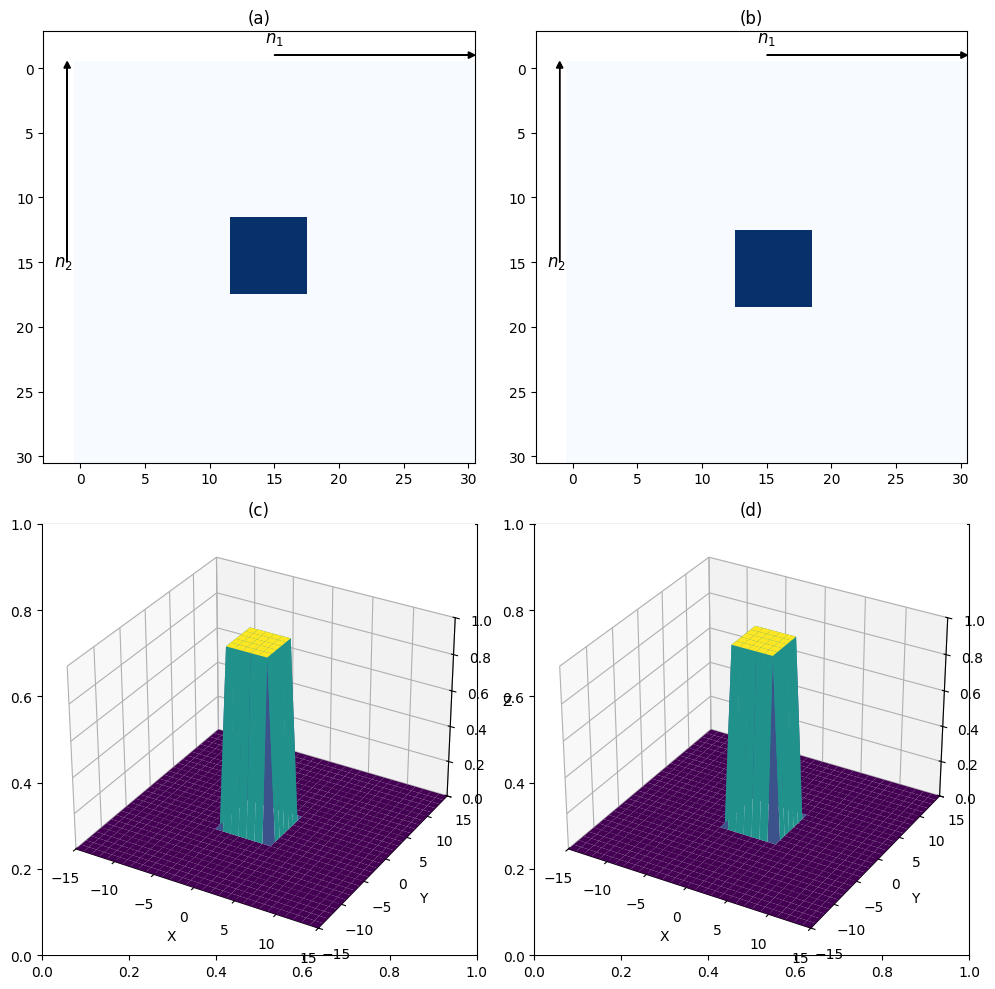

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the size of the grid
size = 31
half_size = size // 2

# Create an empty grid and a grid with a shifted square
grid = np.zeros((size, size))
shifted_grid = np.zeros((size, size))

# Define the square dimensions and initial position
square_size = 6
start = half_size - square_size // 2
end = start + square_size

# Add a square in the middle of the grid
grid[start:end, start:end] = 1

# Shift the square to the right and down by 1 pixel
shift_x, shift_y = 1, 1
shifted_grid[start + shift_y:end + shift_y, start + shift_x:end + shift_x] = 1

# Set up the figure and axes
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot the grids as images
axs[0, 0].imshow(grid, cmap='Blues', interpolation='nearest')
axs[0, 0].set_title('(a)')
axs[0, 0].arrow(-1, half_size, 0, -half_size, head_width=0.5, head_length=0.5, fc='black', ec='black')
axs[0, 0].arrow(half_size, -1, half_size, 0, head_width=0.5, head_length=0.5, fc='black', ec='black')
axs[0, 0].text(-2, half_size, r'$n_2$', fontsize=12, verticalalignment='center')
axs[0, 0].text(half_size, -2, r'$n_1$', fontsize=12, horizontalalignment='center')

axs[0, 1].imshow(shifted_grid, cmap='Blues', interpolation='nearest')
axs[0, 1].set_title('(b)')
axs[0, 1].arrow(-1, half_size, 0, -half_size, head_width=0.5, head_length=0.5, fc='black', ec='black')
axs[0, 1].arrow(half_size, -1, half_size, 0, head_width=0.5, head_length=0.5, fc='black', ec='black')
axs[0, 1].text(-2, half_size, r'$n_2$', fontsize=12, verticalalignment='center')
axs[0, 1].text(half_size, -2, r'$n_1$', fontsize=12, horizontalalignment='center')

# Plot the 3D surface plots
X, Y = np.meshgrid(np.arange(size) - half_size, np.arange(size) - half_size)

ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax3.plot_surface(X, Y, grid, cmap='viridis', edgecolor='none')
ax3.set_title('(c)')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
ax3.set_xlim(-half_size, half_size)
ax3.set_ylim(-half_size, half_size)
ax3.set_zlim(0, 1)

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.plot_surface(X, Y, shifted_grid, cmap='viridis', edgecolor='none')
ax4.set_title('(d)')
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.set_zlabel('Z')
ax4.set_xlim(-half_size, half_size)
ax4.set_ylim(-half_size, half_size)
ax4.set_zlim(0, 1)

# hapus grid plt
# for ax in axs.flatten():
#     ax.axis('off')

plt.tight_layout()
plt.show()


Hasil POC : [array([[[0.03883672],
        [0.01321158],
        [0.07007442],
        [0.00607494],
        [0.01114514],
        [0.10618181],
        [0.07541152]],

       [[0.18954276],
        [0.08670808],
        [0.14888165],
        [0.04682288],
        [0.07884937],
        [0.10720561],
        [0.08733092]],

       [[0.11825983],
        [0.07887009],
        [0.00901253],
        [0.09018904],
        [0.0106506 ],
        [0.05513536],
        [0.28212601]],

       [[0.16641246],
        [0.22348223],
        [0.06438788],
        [0.17279756],
        [0.360496  ],
        [0.44613409],
        [0.02845735]],

       [[0.11728038],
        [0.20467072],
        [0.09945857],
        [0.24736037],
        [0.16574587],
        [0.11258344],
        [0.20205465]],

       [[0.01205041],
        [0.12067459],
        [0.05438303],
        [0.10184578],
        [0.05489794],
        [0.02293349],
        [0.03073642]],

       [[0.00457336],
        [0.06500455],
       

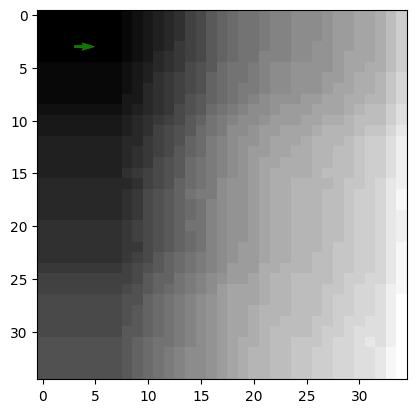

In [12]:
# Extraction Feature POC, Vektor, Quadran Test
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import matplotlib.patches as patches
from feature_extraction.poc import POC
from feature_extraction.vektor import Vektor
from feature_extraction.quadran import Quadran

# Load images
# image1 = cv2.imread('dataset/casme_custom_from_one/Happiness/01_EP02_01f/img1.jpg', cv2.IMREAD_GRAYSCALE)
# image2 = cv2.imread('dataset/casme_custom_from_one/Happiness/01_EP02_01f/img70.jpg', cv2.IMREAD_GRAYSCALE)
# image1 = cv2.imread('temp/eye_left_01.jpg', cv2.IMREAD_GRAYSCALE)
# image2 = cv2.imread('temp/eye_left_70.jpg', cv2.IMREAD_GRAYSCALE)
image1 = cv2.imread('testing/frame_01_blok_1.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('testing/frame_70_blok_1.jpg', cv2.IMREAD_GRAYSCALE)

block_size = 7

# Inisiasi class POC
initPOC = POC(image1, image2, block_size)
# Pemanggilan fungsi pocCalc() untuk menghitung nilai POC disetiap gambar
valPOC = initPOC.getPOC() 
print('Hasil POC :', valPOC)

# Pemanggilan class dan method untuk menampilkan quiver / gambar panah
initQuiv = Vektor(valPOC, block_size)
quivData = initQuiv.getVektor() 
# print('Hasil Vektor :', quivData)

# Quadran
initQuadran = Quadran(quivData) 
quadran = initQuadran.getQuadran()
# print('Hasil Quadran :', quadran)

plt.quiver(quivData[:, 0], quivData[:, 1], quivData[:, 2], quivData[:, 3], scale=1, scale_units='xy', angles='xy', color="r")   

frame_data = {}

for i, quad in enumerate(quadran):
    # --- Setup bagian Nilai Fitur Dataset ---
    # Set data kedalam frame_data sesuai column nya
    frame_data[f'X{i+1}'] = quad[1]
    frame_data[f'Y{i+1}'] = quad[2]
    frame_data[f'Tetha{i+1}'] = quad[3]
    frame_data[f'Magnitude{i+1}'] = quad[4]

print("Nilai Fitur Dataset", frame_data)

# Menampilkan gambar dengan quiver
plt.imshow(np.uint8(image2), cmap='gray')
plt.quiver(quivData[:, 0], quivData[:, 1], quivData[:, 2], quivData[:, 3], scale=1, scale_units='xy', angles='xy', color="g")

# num = 1
# for rect_def in valPOC[2]:
#     x, y, width, height = rect_def
    
#     rects = patches.Rectangle((x,y), width,height, edgecolor='r', facecolor='none') 
#     plt.gca().add_patch(rects)
    
#     plt.text(x,y,f'\n{num}', color="red") 
#     num += 1

plt.axis('on') 
# plt.show()

# hapus ruas x dan y
# plt.xticks([])
# plt.yticks([])
plt.show()